## 过拟合与欠拟合现象
以线性回归模型为基础，拟合目标是$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).$$，实验通过变化不同的迭代次数以及最高幂次来调整模型复杂度，数据集可以自行生成，注意区分训练集和验证集

In [21]:
# 生成模拟数据，训练集100条，验证集100条
import torch
import math
import numpy as np

max_degree = 20 # 多项式最高幂次
n_train, n_test = 100, 100
w_true = np.zeros(max_degree)
w_true[0:4] = np.array([5, 1.2, -3.4, 5.6])
# x: 200行1列, 目前仅1个特征x1: x
x1 = np.random.normal(size=(n_train+n_test, 1))
# 从x1生成其他多项式特征, 包括 x0: 1, x2: (x^2/2)等等
X = np.power(x1, np.arange(max_degree).reshape(1, -1))
X.shape, X[0, :]

((200, 20),
 array([ 1.00000000e+00, -5.44426680e-01,  2.96400410e-01, -1.61368291e-01,
         8.78532032e-02, -4.78296278e-02,  2.60397255e-02, -1.41767213e-02,
         7.71818532e-03, -4.20198601e-03,  2.28767330e-03, -1.24547038e-03,
         6.78067303e-04, -3.69157931e-04,  2.00979427e-04, -1.09418562e-04,
         5.95703846e-05, -3.24317067e-05,  1.76566864e-05, -9.61277118e-06]))

In [22]:
# 这里采用阶乘来scale各个特征
for i in range(max_degree):
    X[:, i] /= math.gamma(i+1) # gamma(i) = (i+1)!
# 生成标签, 添加噪声
y = np.dot(X, w_true)
y += np.random.normal(scale=0.1, size=y.shape)
X_train, y_train, X_val, y_val = X[:n_train, :], y[:n_train], X[n_train:, :], y[n_train:]
w_true, X_train, y_train, X_val, y_val = [torch.tensor(i, dtype=torch.float32) for i in [w_true, X_train, y_train, X_val, y_val]]
w_true.shape, X_train.shape, y_train.shape, X_val.shape, y_val.shape

(torch.Size([20]),
 torch.Size([100, 20]),
 torch.Size([100]),
 torch.Size([100, 20]),
 torch.Size([100]))

In [44]:
from torch import nn
from torch.utils import data
# 进行训练
def load_data(X, y, batchsize, is_train=True):
    dataset = data.TensorDataset(X, y)
    return data.DataLoader(dataset, shuffle=is_train, batch_size=batchsize)

def train(X_train, y_train, X_val, y_val, num_epoch=400):
    loss = nn.MSELoss()
    input_size = X_train.shape[1]
    model = nn.Sequential(nn.Linear(input_size, 1, bias=False))
    trainer = torch.optim.SGD(model.parameters(), lr=0.01)
    # 设置batch_size, 构造batch_iter
    train_iter = load_data(X_train, y_train, batchsize=X_train.shape[0])
    # 进行训练
    train_loss = []
    val_loss = []
    for epoch in range(num_epoch):
        for X, y in train_iter:
            l = loss(model(X), y.reshape(-1,1))
            trainer.zero_grad()
            l.backward()
            trainer.step()
        with torch.no_grad():
            train_loss.append(loss(model(X_train), y_train.reshape(-1,1)))
            val_loss.append(loss(model(X_val), y_val.reshape(-1,1)))
    return train_loss, val_loss, model[0].weight.data

from matplotlib import pyplot as plt
def lossPlot(train_loss, val_loss, a=1e-3, b=50):
    plt.plot(range(len(train_loss)), train_loss, label="train loss", linestyle=":")
    plt.plot(range(len(val_loss)), val_loss, label="test loss", linestyle="--")
    plt.legend()
    plt.ylim(a, b)
    plt.show()


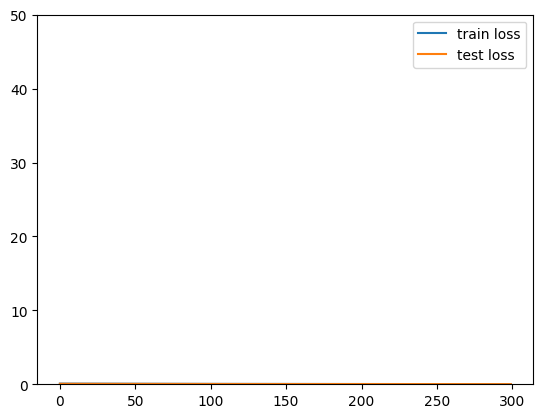

tensor([[ 4.9963,  1.3628, -3.4081,  5.3492]])

In [45]:
def demostrate(dim=4, num_epoch=400, st=0, a=0, b=50):
    _train, _val = X_train[:, :dim], X_val[:, :dim]
    tl, vl, w = train(_train, y_train, _val, y_val, num_epoch=num_epoch)
    lossPlot(tl[st:], vl[st:], a, b)
    return w
# 正常情况
demostrate(dim=4, num_epoch=800, st=500)

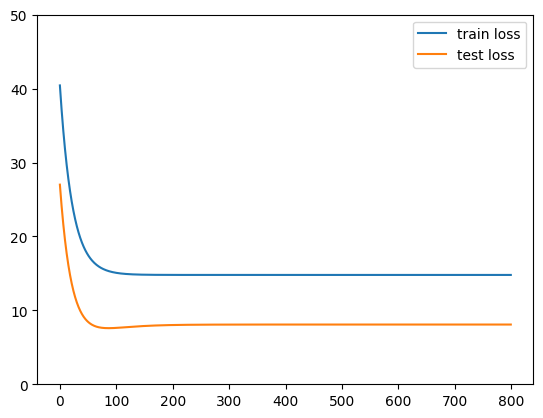

tensor([[3.1109, 4.0716]])

In [46]:
demostrate(dim=2, num_epoch=800)

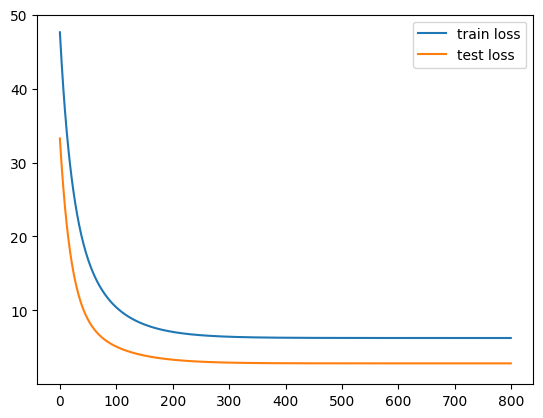

tensor([[ 5.2322,  4.2603, -3.7694]])

In [42]:
demostrate(dim=3, num_epoch=800)

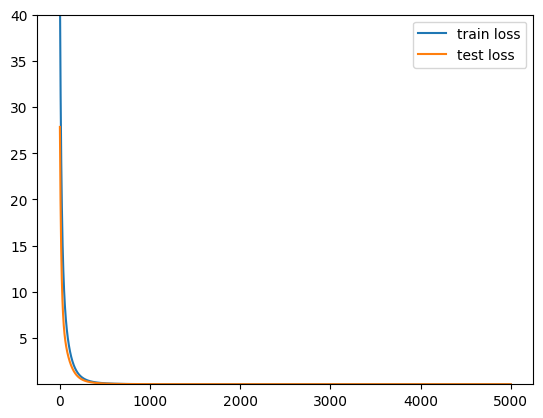

tensor([[ 4.9835,  1.2081, -3.3870,  5.5952]])

In [52]:
demostrate(dim=4, num_epoch=5000, st=0, a=1e-4, b=40)

#### Dataset+DataLoader--创建和读取自己的数据集
`from torch.utils.data import Dataset, DataLoader`
[Pytorch（五）入门：DataLoader 和 Dataset](https://blog.csdn.net/zw__chen/article/details/82806900)
1. Dataset: (deal_dataset = TensorDataset(x_data, y_data))

2. DataLoader: DataLoader是一个比较重要的类，它为我们提供的常用操作有：batch_size(每个batch的大小), shuffle(是否进行shuffle操作), num_workers(加载数据的时候使用几个子进程)

## 问题在哪里？
没错，我知道如何生成数据集，并使用小批量迭代器，最后得到的参数看起来十分贴合预期了，然而我的目的是想要观察到过拟合的现象，这似乎并不明显。就目前来看，我似乎确实应该学习一下d2l中的可视化技术了，我想，我必须看到他，那么首先就CV一下吧

In [53]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])
features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

In [54]:
features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.8026],
         [ 1.0829]]),
 tensor([[ 1.0000e+00, -8.0255e-01,  3.2205e-01, -8.6153e-02,  1.7286e-02,
          -2.7745e-03,  3.7112e-04, -4.2549e-05,  4.2685e-06, -3.8063e-07,
           3.0548e-08, -2.2287e-09,  1.4906e-10, -9.2020e-12,  5.2751e-13,
          -2.8223e-14,  1.4157e-15, -6.6833e-17,  2.9798e-18, -1.2587e-19],
         [ 1.0000e+00,  1.0829e+00,  5.8635e-01,  2.1166e-01,  5.7301e-02,
           1.2410e-02,  2.2399e-03,  3.4652e-04,  4.6906e-05,  5.6439e-06,
           6.1118e-07,  6.0169e-08,  5.4298e-09,  4.5231e-10,  3.4986e-11,
           2.5258e-12,  1.7095e-13,  1.0890e-14,  6.5515e-16,  3.7340e-17]]),
 tensor([2.4080, 5.6138]))

In [55]:
import sys
sys.path.append("../")
from MyUtils import d2laiUtils as d2l

def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [ ]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())